<a href="https://colab.research.google.com/github/venkiharvgit/csci-e-599a-2024-cybersecurity/blob/main/graph_similarity_using_karateclub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q karateclub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.21.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 1.3.5 which is incompatible.
orbax-checkpoint 0.4.4 requires j

In [4]:
import random as random
import math
from typing import List

import networkx as nx
import karateclub as kc
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
dir_data = '/content/drive/MyDrive/capstone-project/data/chunked_data/'
dir_model = '/content/drive/MyDrive/capstone-project/model'
dir_bot_iot = "/content/drive/MyDrive/capstone-project/data/parquet/NF-BoT-IoT-v2.parquet"

cols = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT','L4_DST_PORT', 'PROTOCOL', 'IN_BYTES', 'OUT_BYTES',
       'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS','Label']

In [6]:
#I'm just looking at the non-attack data for now
raw_data = pd.read_parquet(dir_bot_iot,
                           columns = cols,
                           filters = [("Label", "=", 0)])

In [7]:
raw_data['src_id'] = raw_data['IPV4_SRC_ADDR'].astype(str) + ":" + raw_data['L4_SRC_PORT'].astype(str)
raw_data['dst_id'] = raw_data['IPV4_DST_ADDR'].astype(str) + ":" + raw_data['L4_DST_PORT'].astype(str)
raw_data.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'Label'], axis=1, inplace=True)

In [8]:
raw_data.head()

,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,src_id,dst_id
0,17,72,0,1,0,0,0,192.168.100.147:60030,192.168.217.2:53
1,6,205296,0,728,0,0,4292513,192.168.100.6:80,192.168.100.3:80
2,6,44,180,1,2,22,4293342,192.168.100.3:80,192.168.100.148:44903
3,17,215322,224794,230,229,0,4293391,192.168.100.46:3456,192.168.100.5:80
4,6,44,40,1,1,22,4294936,192.168.100.3:80,192.168.100.149:56727


In [9]:
def calc_embeddings(df_list: List[pd.DataFrame],
                    model_type: kc.graph_embedding) -> np.ndarray:
  """
  Calculates embeddings from a list of pandas edgelists using network edge
  and karateclub
  """

  all_graphs = []

  for i in df_list:
    #Create a single Graph
    graph = nx.from_pandas_edgelist(i, 'src_id', 'dst_id', create_using=nx.DiGraph(), edge_attr=True)
    mapping = {node: i for i, node in enumerate(graph.nodes())}
    graph = nx.relabel_nodes(graph, mapping)

    all_graphs.append(graph)

  model = model_type()
  model.fit(all_graphs)
  embeds = model.get_embedding()

  return cosine_similarity(embeds), embeds

In [10]:
def plot_pairwise_heatmap(simil: np.ndarray, add_mask:bool) -> plt:

  # Mask Upper triangular part
  mask = np.tril(np.ones_like(simil, dtype=bool))

  sns.set(font_scale=1.2)
  plt.figure(figsize=(8, 6))
  sns.heatmap(simil, mask = mask if add_mask else None , annot=True, cmap='coolwarm', fmt='.2f',
              xticklabels=[f"{i+1}" for i in range((simil.shape[0]))],
              yticklabels=[f"{i+1}" for i in range((simil.shape[1]))])
  plt.title('Pairwise Cosine Similarities')
  plt.xlabel('Subgraph')
  plt.ylabel('Subgraph')

  return plt

# Testing for Self Similarity
I first test how multiple samples (with replacement) of a single graph relate to the original graph AND to each other

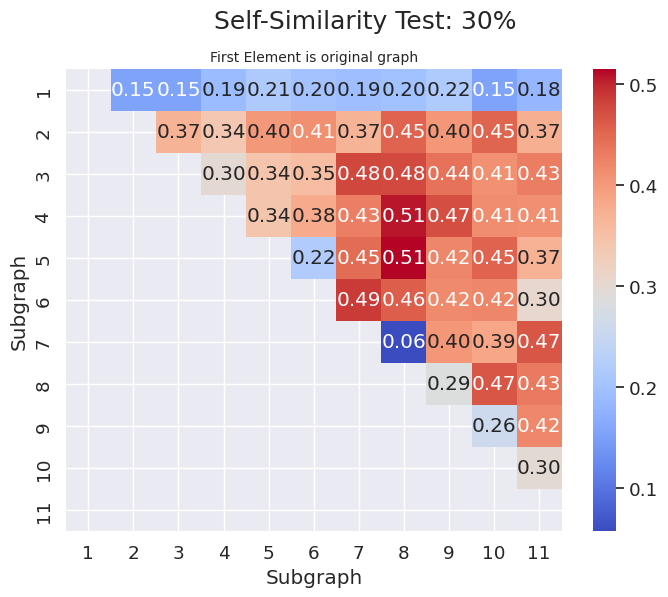

In [13]:
samples = [raw_data] + [raw_data.sample(frac=0.3, replace=True, random_state = seed) for seed in range(10)]
simil, embeds = calc_embeddings(samples, kc.Graph2Vec)

plot = plot_pairwise_heatmap(simil, True)
plot.suptitle("Self-Similarity Test: 30%", fontsize=18)
plot.title("First Element is original graph", fontsize=10)
plot.show()

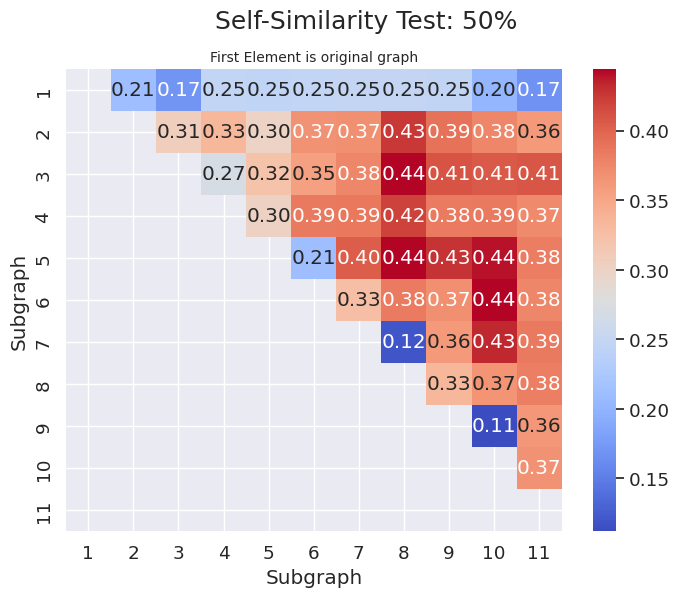

In [14]:
samples = [raw_data] + [raw_data.sample(frac=0.5, replace=True, random_state = seed) for seed in range(10)]
simil, embeds = calc_embeddings(samples, kc.Graph2Vec)

plot = plot_pairwise_heatmap(simil, True)
plot.suptitle("Self-Similarity Test: 50%", fontsize=18)
plot.title("First Element is original graph", fontsize=10)
plot.show()

# Node Drop Test
I randomly drop 1% of nodes. Each iteration drops an additional 1% of nodes

In [15]:
all_unique_nodes = list(set(raw_data.src_id.unique()) | set(raw_data.dst_id.unique()))
len(all_unique_nodes)

101790

In [16]:
n_in_sample = math.ceil(len(all_unique_nodes)/100)
n_in_sample

1018

In [17]:
random.seed(1001)

node_drop_simil = []

for _ in range(10):
  random.shuffle(all_unique_nodes)
  n_samples = 10 #Number of Percentiles Dropped

  node_drop_list = [raw_data] + [raw_data[~raw_data['src_id'].isin(all_unique_nodes[:n_in_sample*i]) & ~raw_data['dst_id'].isin(all_unique_nodes[:n_in_sample*i])] for i in range(1, n_samples)]
  simil, embeds = calc_embeddings(node_drop_list, kc.Graph2Vec)
  node_drop_simil.append(simil[0,])


node_drop_simil = np.array(node_drop_simil)

Text(63.25, 0.5, 'Subgraph')

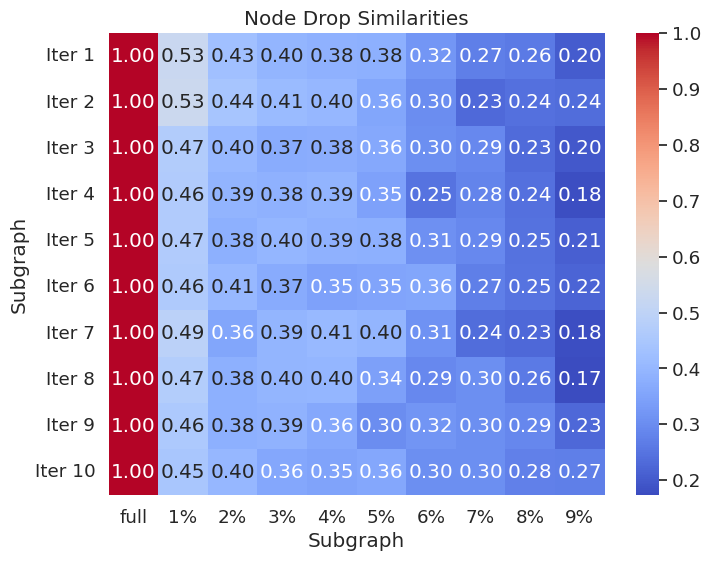

In [37]:
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(node_drop_simil , annot=True, cmap='coolwarm', fmt='.2f',
            xticklabels=["full"] + [f"{i+1}%" for i in range((node_drop_simil.shape[0]-1))],
            yticklabels=[f"Iter {i+1}" for i in range((node_drop_simil.shape[1]))])
plt.title('Node Drop Similarities')
plt.xlabel('Subgraph')
plt.ylabel('Subgraph')

Text(0.5, 1.0, 'Average Similarity by Percent Nodes Dropped')

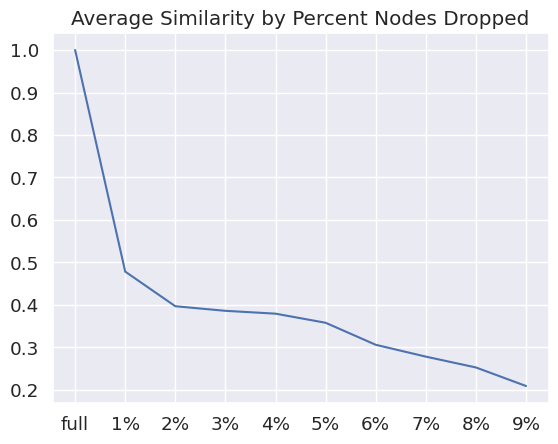

In [36]:
column_means = np.mean(node_drop_simil, axis=0)
pct = ["full"] + [f"{i+1}%" for i in range((simil.shape[0]-1))]


plt.plot(pct, column_means)
plt.title("Average Similarity by Percent Nodes Dropped")

# Edge Drop Test
Recall that a row in the pandas dataframe is an edge. So doing samples on the dataset is the same as dropping an edge

In [32]:
edge_drop_simil = []

for i in range(10):
  #Here, using i to generate new, but repeatable, random states

  sample_sizes = range(99, 90, -1) #I invert the ordering to make it comparable to above charts
  rs = range(90+(i*100), 100+(i*100))

  edge_drop_samples = [raw_data] + [raw_data.sample(frac = frac/100, random_state = rs) for frac, rs in zip(sample_sizes, rs)]

  simil, embeds = calc_embeddings(edge_drop_samples, kc.Graph2Vec)
  edge_drop_simil.append(simil[0,])


edge_drop_simil = np.array(edge_drop_simil)

Text(63.25, 0.5, 'Subgraph')

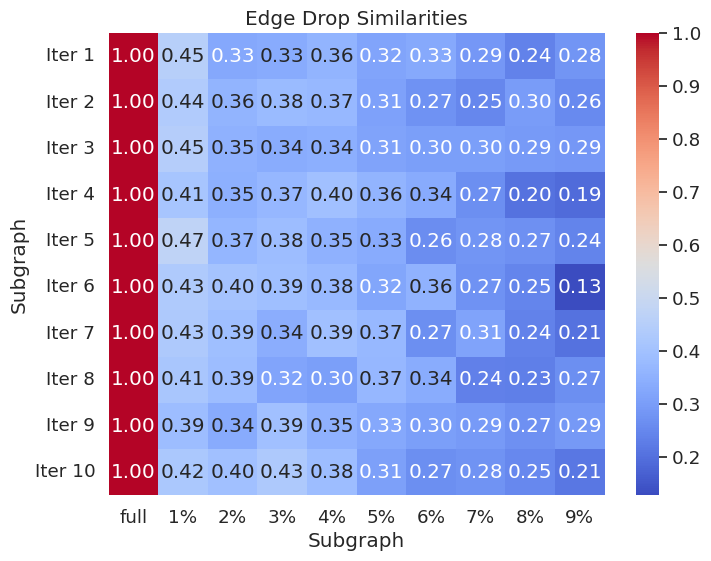

In [39]:
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 6))
sns.heatmap(edge_drop_simil , annot=True, cmap='coolwarm', fmt='.2f',
            xticklabels=["full"] + [f"{i+1}%" for i in range((edge_drop_simil.shape[0]-1))],
            yticklabels=[f"Iter {i+1}" for i in range((edge_drop_simil.shape[1]))])
plt.title('Edge Drop Similarities')
plt.xlabel('Subgraph')
plt.ylabel('Subgraph')

Text(0.5, 1.0, 'Average Similarity by Percent Edges Dropped')

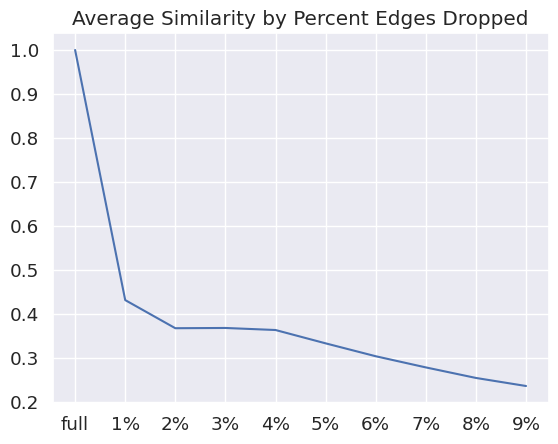

In [40]:
column_means = np.mean(edge_drop_simil, axis=0)
pct = ["full"] + [f"{i+1}%" for i in range((edge_drop_simil.shape[0]-1))]


plt.plot(pct, column_means)
plt.title("Average Similarity by Percent Edges Dropped")